<a href="https://colab.research.google.com/github/valerian-drmt/Finance/blob/main/Projects/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Setup

In [34]:
!pip install vectorbt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

# 2) Get and Modify Data

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [ ]:
#data_request = vbt.BinanceData.download("BTCUSDT", start="2025-04-14", end="2025-04-17", interval="1m")
data_request = vbt.YFData.download("BTC-USD", start="2025-04-14", end="2025-04-17", interval="1m")
data = data_request.get()
print(data.head())
print(data["Volume"].iloc[-1])
time.sleep(3)

data_request = data_request.update()
data = data_request.get()
print(data["Volume"].iloc[-1])


                                   Open          High           Low  \
Datetime                                                              
2025-04-14 00:01:00+00:00  83706.945312  83706.945312  83706.945312   
2025-04-14 00:03:00+00:00  83729.085938  83729.085938  83729.085938   
2025-04-14 00:04:00+00:00  83800.125000  83800.125000  83800.125000   
2025-04-14 00:06:00+00:00  83708.820312  83708.820312  83708.820312   
2025-04-14 00:07:00+00:00  83785.421875  83785.421875  83785.421875   

                                  Close     Volume  Dividends  Stock Splits  
Datetime                                                                     
2025-04-14 00:01:00+00:00  83706.945312          0        0.0           0.0  
2025-04-14 00:03:00+00:00  83729.085938  132960256        0.0           0.0  
2025-04-14 00:04:00+00:00  83800.125000  678313984        0.0           0.0  
2025-04-14 00:06:00+00:00  83708.820312   23078912        0.0           0.0  
2025-04-14 00:07:00+00:00  83785.4

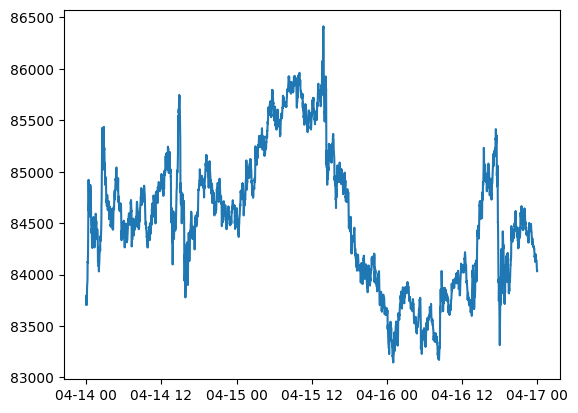

In [ ]:
data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
plt.plot(data.index,data["Close"])

input = pd.DataFrame(index = data.index, data = {"Close":data["Close"]})
input = (input-input.min())/(input.max()-input.min())

In [ ]:
def split_data(input, lookback, size_test_prct):
    data_raw = np.array(input) # convert to numpy array
    data = []
    lookback+=1 # +1 for output variable

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    test_set_size = int(np.round(size_test_prct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]

# 3) Setup LSTM Definition

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

Function to Delete Training Data Variables

In [35]:
# @title
def del_train_data(list):
  for var in list:
    if var in locals():
        del globals()[var]

Function to Initialize Metrics Tracking

In [36]:
# @title
def metrics_setup():

  # Tracking
  hist_rmse = np.zeros(num_epochs)
  hist_mae = np.zeros(num_epochs)
  hist_r2 = np.zeros(num_epochs)
  hist_mape = np.zeros(num_epochs)
  MSE = torch.nn.MSELoss(reduction='mean')
  MAE = torch.nn.L1Loss(reduction='mean')

  return [MSE, MAE, hist_rmse,hist_mae,hist_r2,hist_mape]

Function to Update Model Metrics

In [37]:
# @title
def update_metrics(y_train_pred, y_train, MSE, MAE):
  # Compute losses
    mse_value = MSE(y_train_pred, y_train)
    rmse_value = torch.sqrt(mse_value)
    mae_value = MAE(y_train_pred, y_train)

    # Detach predictions for R2 and MAPE
    y_pred_np = y_train_pred.detach().cpu().numpy()
    y_true_np = y_train.detach().cpu().numpy()

    # R² Score
    r2_value = r2_score(y_true_np, y_pred_np)

    # MAPE (add small epsilon to avoid division by zero)
    epsilon = 1e-8
    mape_value = np.mean(np.abs((y_true_np - y_pred_np) / (y_true_np + epsilon))) * 100


    return [mse_value, rmse_value.item(), mae_value.item(), r2_value, mape_value]

# 4) Setup Data Pisplay Definition

Function to Plot Training Metrics Over Epochs

In [38]:
# @title
# Affichage des métriques
def plot_metrics(hist_rmse,hist_mae,hist_r2,hist_mape):
  fig, axs = plt.subplots(1, 3, figsize=(18, 5))

  # RMSE & MAE
  axs[0].plot(hist_rmse, label="RMSE")
  axs[0].plot(hist_mae, label="MAE")
  axs[0].set(title="RMSE & MAE", xlabel="Epoch", ylabel="Error")
  axs[0].legend()

  # R²
  axs[1].plot(hist_r2)
  axs[1].set(title="R² Score", xlabel="Epoch", ylabel="R²")

  # MAPE
  axs[2].plot(hist_mape)
  axs[2].set(title="MAPE (%)", xlabel="Epoch", ylabel="MAPE")

  plt.tight_layout(rect=[0, 0.03, 1, 0.90])
  plt.show()

Function to Plot Model Predictions Against Actual Data

In [39]:
# @title
def plot_train_test_prediction(y_train,y_train_pred,y_test,y_test_pred):
  common_style = {
      'xlabel': 'Sample Index',
      'ylabel': 'Value',
      'legend_loc': 'best',
      'data_color': 'blue',
      'pred_color': 'orange',
      'pred_linestyle': '--',
      'titles': ['Train Data and Model Predictions', 'Test Data and Model Predictions']
  }

  # Create a figure with 1 row and 2 columns of subplots
  fig, ax = plt.subplots(1, 2, figsize=(18, 3))

  # Data and prediction lists for loop
  data_and_pred = [
      (y_train.detach().cpu().numpy()[-lookback*5:], y_train_pred.detach().cpu().numpy()[-lookback*5:], 'train'),
      (y_test[-5*lookback:], y_test_pred.detach().cpu().numpy()[-5*lookback:], 'test')
  ]

  # Plot data and predictions
  for i, (data, pred, label_prefix) in enumerate(data_and_pred):
      ax[i].plot(data, label=f'{label_prefix} data', color=common_style['data_color'])
      ax[i].plot(pred, label=f'{label_prefix} prediction', color=common_style['pred_color'], linestyle=common_style['pred_linestyle'])
      ax[i].set_title(common_style['titles'][i])
      ax[i].set_xlabel(common_style['xlabel'])
      ax[i].set_ylabel(common_style['ylabel'])
      ax[i].legend(loc=common_style['legend_loc'])

  # Apply tight layout for better spacing
  plt.tight_layout()
  plt.show()

Function to Display Model Performance Metrics

In [40]:
# @title
def show_metrics(y_test, y_test_pred, hist_rmse, hist_mae, hist_r2, hist_mape):
    y_test_pred_np = y_test_pred.detach().cpu().numpy()
    y_test_np = y_test.detach().cpu().numpy()

    # Compute losses for the test set
    mse_test = MSE(y_test_pred, y_test)
    rmse_test = torch.sqrt(mse_test).item()
    mae_test = MAE(y_test_pred, y_test).item()

    # Compute R² Score for the test set
    r2_value_test = r2_score(y_test_np, y_test_pred_np)

    # MAPE for the test set (add small epsilon to avoid division by zero)
    epsilon = 1e-8
    mape_value_test = np.mean(np.abs((y_test_np - y_test_pred_np) / (y_test_np + epsilon))) * 100

    # Create a dataframe with train and test metrics
    metrics_data = {
        'Train': [hist_rmse, hist_mae, hist_r2, hist_mape],
        'Test': [rmse_test, mae_test, r2_value_test, mape_value_test]
    }

    metrics_df = pd.DataFrame(metrics_data, index=['RMSE', 'MAE', 'R²', 'MAPE'])

    # Print the dataframe
    print(metrics_df)

In [41]:
lookback = 20 # choose sequence length
size_test_prct = 0.3
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

# 5) Train, Test and Plot LSTM Model

Epoch 1 / RMSE: 0.55358 / MAE: 0.51707 / R²: -6.94136 / MAPE: 80963.09%
Epoch 10 / RMSE: 0.20159 / MAE: 0.16137 / R²: -0.05307 / MAPE: 1430325.12%
Epoch 20 / RMSE: 0.16970 / MAE: 0.13500 / R²: 0.25374 / MAPE: 1473836.25%
Epoch 30 / RMSE: 0.09389 / MAE: 0.07326 / R²: 0.77155 / MAPE: 709908.69%
Epoch 40 / RMSE: 0.06154 / MAE: 0.04707 / R²: 0.90187 / MAPE: 587461.56%
Epoch 50 / RMSE: 0.04291 / MAE: 0.03200 / R²: 0.95228 / MAPE: 312386.31%
Epoch 60 / RMSE: 0.03773 / MAE: 0.02680 / R²: 0.96312 / MAPE: 340787.12%
Epoch 70 / RMSE: 0.03470 / MAE: 0.02472 / R²: 0.96880 / MAPE: 286130.22%
Epoch 80 / RMSE: 0.03271 / MAE: 0.02334 / R²: 0.97227 / MAPE: 110662.37%
Epoch 90 / RMSE: 0.03120 / MAE: 0.02212 / R²: 0.97478 / MAPE: 146932.50%
Epoch 100 / RMSE: 0.03030 / MAE: 0.02144 / R²: 0.97621 / MAPE: 152922.00%
---------------------------------
Training time: 56.92469763755798
---------------------------------
              Train       Test
RMSE       0.030296   0.032295
MAE        0.021438   0.022304


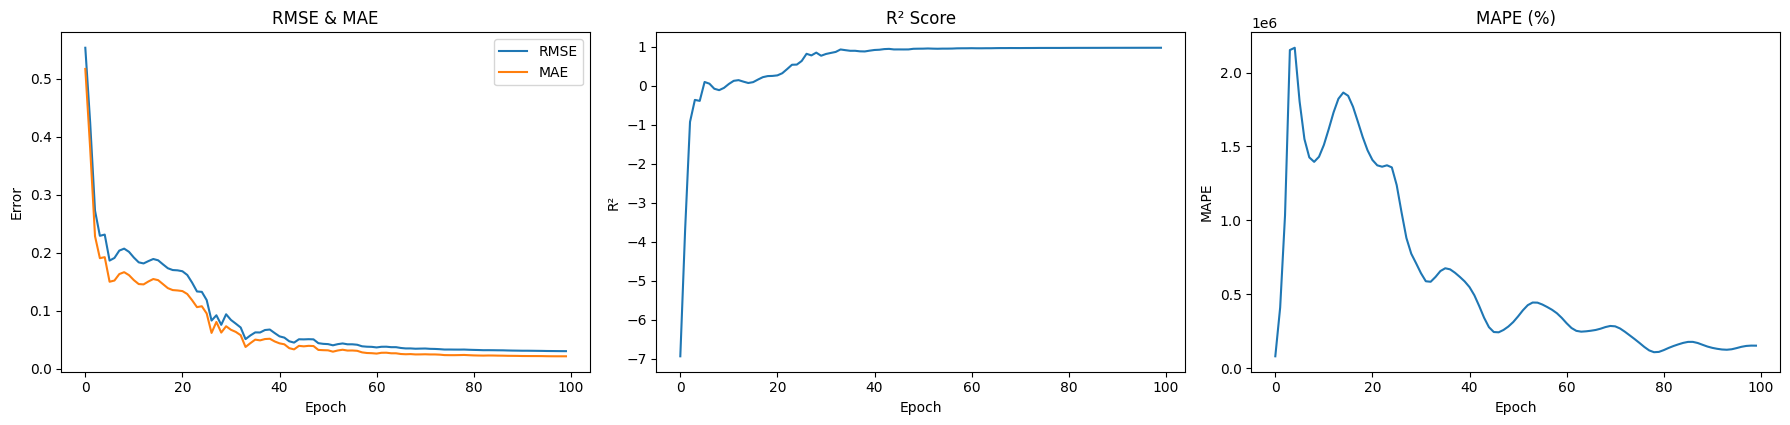

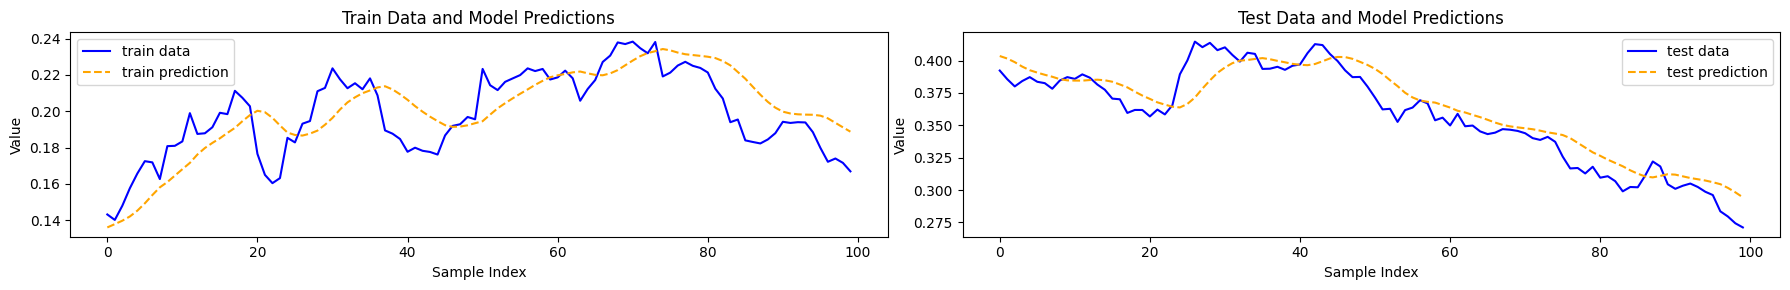

In [42]:
# Supprimer les data du train précédent
del_train_data(['model', 'optimiser', 'MSE', 'MAE'])

#-------------------------------------------------------------------------------
# Model Setup
x_train, y_train, x_test, y_test = split_data(input, lookback, size_test_prct)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss functions
MSE, MAE, hist_rmse, hist_mae, hist_r2, hist_mape = metrics_setup()

#-------------------------------------------------------------------------------

start_time = time.time()

for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

    mse_value, hist_rmse[t], hist_mae[t], hist_r2[t], hist_mape[t] = update_metrics(y_train_pred, y_train, MSE, MAE)

    # Logging
    if (t+1)%10==0 or t==0:
      print(f"Epoch {t+1} / RMSE: {hist_rmse[t]:.5f} / MAE: {hist_mae[t]:.5f} / R²: {hist_r2[t]:.5f} / MAPE: {hist_mape[t]:.2f}%")

    # Backprop
    optimiser.zero_grad()
    mse_value.backward()
    optimiser.step()

training_time = time.time()-start_time
print("---------------------------------\nTraining time: {}\n---------------------------------".format(training_time))

model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
#-------------------------------------------------------------------------------
# Affichage des métriques
show_metrics(y_test,y_test_pred,hist_rmse[-1],hist_mae[-1],hist_r2[-1],hist_mape[-1])
print("---------------------------------")
plot_metrics(hist_rmse,hist_mae,hist_r2,hist_mape)

# Affichage des graphiques avec les prédictions
plot_train_test_prediction(y_train,y_train_pred,y_test,y_test_pred)
